In [1]:
import os
import cv2
import glob
from math import atan2, asin
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as aug
from albumentations import (HorizontalFlip, VerticalFlip,OneOf, ShiftScaleRotate, Normalize, Resize, Compose,Cutout, GaussNoise, RandomRotate90, Transpose, RandomBrightnessContrast, RandomCrop)
from albumentations import ElasticTransform, GridDistortion, OpticalDistortion, Blur, RandomGamma
from albumentations.pytorch import ToTensor
from albumentations.augmentations.transforms import CropNonEmptyMaskIfExists
import torch
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.models as models
import time
import random
import scipy.io
import random
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state=24)

seed = 23
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.set_default_tensor_type("torch.FloatTensor")

#### Setting Random Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(24)

### Visualisation

In [3]:
blood=glob.glob('Blood_noblood/blood/*.jpg')
noblood=glob.glob('Blood_noblood/noblood/*.jpg')
faces=glob.glob('Blood_noblood/faces/*')

Function to read the .pgm files 

In [4]:
def read_pgm(path):
    """
        This function was modified from stackoverflow as I had not 
        previously worked with .pgm files before. Other alternatives
        were using PIL library.
    """
    pgmf = open(path, 'rb')
    assert pgmf.readline() == b'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        row = []
        for y in range(width):
            row.append(ord(pgmf.read(1)))
        raster.append(row)
    return np.asarray(raster)

Just checking the sizes of ,pgm extension images

In [5]:
for i in random.choices(faces, k=20):
    a = read_pgm(i)
    print(a.shape)

(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)
(192, 168)


In [6]:
def plot(path):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        if(path[i][-3:]!='pgm'):
            img = plt.imread(path[i])
        else:
            image
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

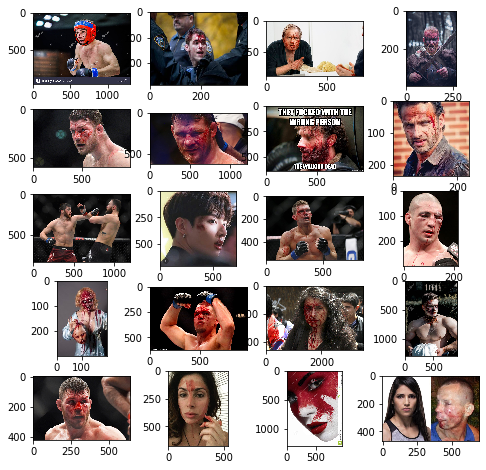

In [7]:
plot(blood)

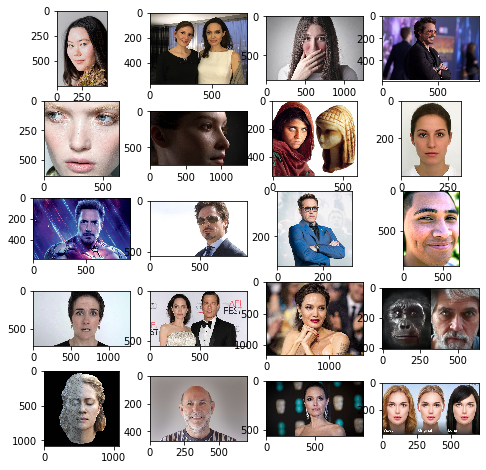

In [8]:
plot(noblood)

### Creating a Pandas DataFrame which will later be used in the Dataset class

In [9]:
df = pd.DataFrame(columns=['Image_Path', 'Blood'])
df.Image_Path = blood+noblood
df.Blood[:401] = 1
df.Blood[401:] = 0

Equally distributed data

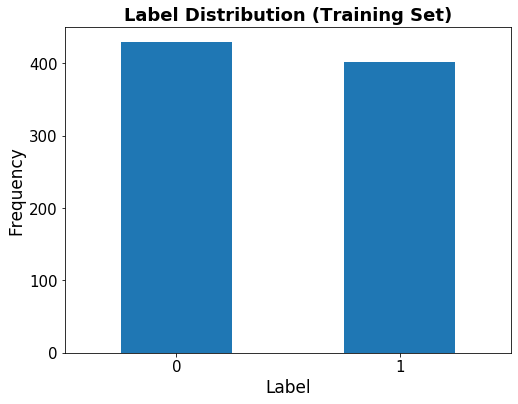

In [10]:
df['Blood'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(8,6), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [11]:
df.head()

,Image_Path,Blood
0,Blood_noblood/blood/blood_91.jpg,1
1,Blood_noblood/blood/blood_151.jpg,1
2,Blood_noblood/blood/blood_232.jpg,1
3,Blood_noblood/blood/blood_286.jpg,1
4,Blood_noblood/blood/blood_82.jpg,1


### Eliminating images that are corrupt

In [12]:
print("Length of DataFrame : ", len(df))

Length of DataFrame :  830


In [13]:
count=0
for i in range(len(df.Image_Path)):
    try:
        image = cv2.imread(df.loc[i].Image_Path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
    except:
        print(i)
        df.drop(i, inplace = True)
        count+=1

29
270
360
472


In [14]:
print("Length of DataFrame after removing corrupt images: ", len(df))

Length of DataFrame after removing corrupt images:  826


Shuffling the DataFrame

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
df.head()

,Image_Path,Blood
0,Blood_noblood/noblood/noblood_326.jpg,0
1,Blood_noblood/blood/blood_150.jpg,1
2,Blood_noblood/blood/blood_228.jpg,1
3,Blood_noblood/noblood/noblood_304.jpg,0
4,Blood_noblood/blood/blood_261.jpg,1


### Class for Dataset

In [17]:
class Blood_Dataset(Dataset):
    def __init__(self, df, phase='train', transform =True):
        self.df = df
        self.phase = phase
        self.aug = get_transforms(self.phase)
        self.transform = transform
    def __getitem__(self,idx):
        image = cv2.imread(self.df.loc[idx].Image_Path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = cv2.resize(image, (512, 512)) # only resizing during test time 
        label = self.df.loc[idx].Blood
        label = label.reshape(1,)
        augment = self.aug(image =image) # augmentation takes care of the image size 
        image = augment['image']         # as random cropping is used.
        return image,label
    def __len__(self):
        return len(self.df)

In [18]:
def get_transforms(phase):
    """
        This function returns the transformation list.
        These are some commonly used augmentation techniques that 
        I believed would be useful.
    """
    list_transforms = []
    list_transforms.extend([RandomCrop(512, 512, always_apply=True, p=1.0)])
    if phase == "train":
        list_transforms.extend(
            [
            Cutout(num_holes=4, p=0.5),
            ShiftScaleRotate(p=1,border_mode=cv2.BORDER_CONSTANT),
            OneOf([
            ElasticTransform(p=0.1, alpha=1, sigma=50, alpha_affine=50,border_mode=cv2.BORDER_CONSTANT),
            GridDistortion(distort_limit =0.05 ,border_mode=cv2.BORDER_CONSTANT, p=0.1),
            OpticalDistortion(p=0.1, distort_limit= 0.05, shift_limit=0.2,border_mode=cv2.BORDER_CONSTANT)                  
            ], p=0.3),
             OneOf([
            GaussNoise(var_limit=1.0),
            Blur(),
            Blur(blur_limit=7)
            ], p=0.4),    
            RandomGamma(p=0.8)
        ]
      )
    list_transforms.extend(
        [
            Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225], p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

In [19]:
### This function retur

In [20]:
def provider(phase, df, batch_size=16, num_workers=0):
    """
        This function returns the dataloader according to 
        the phase passed.
    """
    if phase == 'train' :
        image_dataset = Blood_Dataset(df)
    else:
        image_dataset = Blood_Dataset(df, transform = False)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [21]:
# dl = provider('train', df)

In [22]:
# for x, y in dl:
#     print(x.shape)
#     plt.imshow(x[1].reshape(224, 224, 3))
#     print(y.shape)
#     break

In [23]:
# !git clone https://github.com/mgrankin/over9000.git

In [24]:
import sys
sys.path.insert(0, 'over9000/')

In [25]:
from over9000 import Over9000

In [26]:
class Trainer(object):
    """
        This class takes care of training and validation of our model
    """
    def __init__(self, model, df_train, df_val, bs, lr, epochs, model_name="model"):
        self.batch_size = bs
        self.accumulation_steps = 1
        self.lr = lr
        self.model_name = model_name
        self.num_epochs = epochs
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.FloatTensor")
        self.net = model
        self.dataframe = {'train': df_train, 'val': df_val}
        self.losses = {phase: [] for phase in self.phases}
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = Over9000(self.net.parameters(),lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True,factor = 0.5,min_lr = 1e-5)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                phase=phase,
                df = self.dataframe[phase],
                batch_size=self.batch_size
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        targets = targets.type("torch.FloatTensor")
        targets = targets.to(self.device)
        preds = self.net(images)
        preds.to(self.device)
        loss = self.criterion(preds,targets)
        return loss

    def iterate(self, epoch, phase):
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(tk0): 
            images, targets = batch
            loss= self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        torch.cuda.empty_cache()
        print(f'loss:{epoch_loss}')
        return epoch_loss

    def train_end(self):
        train_loss = self.losses["train"]
        val_loss = self.losses["val"]
        df_data=np.array([train_loss,val_loss]).T
        df = pd.DataFrame(df_data,columns = ['train_loss','val_loss'])
        df.to_csv(self.model_name+".csv")
    
    def predict(self):
        self.net.eval()
        with torch.no_grad():
            self.iterate(1,'test')
        print('Done')

    def start(self):
        for epoch in range(self.num_epochs):
            train_loss = self.iterate(epoch, "train")
            self.losses["train"].append(train_loss)
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.losses["val"].append(val_loss)
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./"+self.model_name+".pth")
            print()
            self.train_end()

In [27]:
from efficientnet_pytorch import EfficientNet

In [70]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [71]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

To print .pgm files using PIL

In [119]:
# from PIL import Image
# f = Image.open(faces[100])
# f.show()

### Training with K-Fold Stratified Split
The folds in case of a stratified split are made by preserving the percentage of samples for each class.

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
for i, (train_index, val_index) in enumerate(skf.split(df.Image_Path, df['Blood'])):
    print(22*"====")
    df_train, df_test = df.loc[train_index], df.loc[val_index]
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    trainer = Trainer(model, df_train, df_test, 16, 1e-3, 20, model_name='efficientnet-b0_fold_'+str(i))
    trainer.start()

Starting epoch: 0 | phase: train | ⏰: 10:44:33


KeyboardInterrupt: 

In [ ]:
model2 = EfficientNet.from_pretrained('efficientnet-b1')

In [ ]:
num_ftrs = model2._fc.in_features
model2._fc = nn.Linear(num_ftrs, 1)

In [ ]:
for i, (train_index, val_index) in enumerate(skf.split(df.Image_Path, df['Blood'])):
    print(23*"====")
    df_train, df_test = df.loc[train_index], df.loc[val_index]
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_test.sample(frac=1).reset_index(drop=True)
    trainer = Trainer(model2, df_train, df_test, 16, 1e-3, 20, model_name='efficientnet-b1_fold_'+str(i))
    trainer.start()

### Since the training data is really small I wanted to try a technique called Pseudo Labelling as I had seen many top kagglers use it to increase their model accuracy
[Read about it from here](https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af)

In [28]:
import torch

In [29]:
model = EfficientNet.from_pretrained('efficientnet-b1')

Loaded pretrained weights for efficientnet-b1


In [30]:
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 1)

In [31]:
checkpoint = torch.load('efficientnet-b1_fold_2.pth')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Let's evaluate the model predictions

In [32]:
dl=provider('train', df, batch_size=2)

In [33]:
model.eval()
for x, y in dl:
#     print(x.to('cpu').numpy().shape)
    print("Here's the labels for the batch: ")
    print(y)
    preds = model(x)
    preds = nn.Sigmoid()(preds)
    print("Here are the model outputs: ")
    print(np.uint(preds>0.4))
#     print(preds)
    break

Here's the labels for the batch: 
tensor([[1],
        [1]])
Here are the model outputs: 
[[1]
 [1]]


### Alpha trimming: Ensembling technique
Let us say we have 10 models for prediction. We predict from each of these and sort these probabilities in increasing order and remove initial 2 and the final 2 prediction to get the best averaged out prediction

Let's load the models

In [37]:
def load_model(eff_model, fold):
    model = EfficientNet.from_pretrained('efficientnet-b'+str(eff_model))
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, 1)
    checkpoint = torch.load('efficientnet-b'+str(eff_model)+'_fold_'+str(fold)+'.pth')
    model.load_state_dict(checkpoint['state_dict'])
    return model

#### This function uses the trained models(in my case selecting 6 out of 10) to predict  the class of the image.

In [38]:
def predict(x):
    eff_model = -1
    fold = 0
    preds  =[]
    for i in range(10):
        if i%5 == 0:
            eff_model += 1
            fold = 0
        model = load_model(eff_model, fold)
        print("fold: ", fold+1)
        fold += 1
        pred = model(x)
        pred = nn.Sigmoid()(pred)
        pred = np.uint(pred>0.4)
        print("predicted!")
        preds.append(pred)
    return preds

In [39]:
a = predict(x)

Loaded pretrained weights for efficientnet-b0
fold:  0
predicted!
Loaded pretrained weights for efficientnet-b0
fold:  1
predicted!
Loaded pretrained weights for efficientnet-b0
fold:  2
predicted!
Loaded pretrained weights for efficientnet-b0
fold:  3
predicted!
Loaded pretrained weights for efficientnet-b0
fold:  4
predicted!
Loaded pretrained weights for efficientnet-b1
fold:  0
predicted!
Loaded pretrained weights for efficientnet-b1
fold:  1
predicted!
Loaded pretrained weights for efficientnet-b1
fold:  2
predicted!
Loaded pretrained weights for efficientnet-b1
fold:  3
predicted!
Loaded pretrained weights for efficientnet-b1
fold:  4
predicted!


In [ ]:
a